In [ ]:
!pip install tensorflow
!pip install tensorflow.keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 139.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 160.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 129.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 9.3 MB/s eta 0:00:00


In [ ]:
# ============================
# Imports
# ============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers



/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:82: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


In [ ]:
# cargamos datos
df = pd.read_csv("datos_integrados.csv", parse_dates=["datetime"])


In [ ]:
# ========= 2) Separar por estación
estaciones = df["nombre"].unique()
df_por_estacion = {est: df[df["nombre"] == est].sort_values("datetime").copy() for est in estaciones}

In [ ]:
print(df_por_estacion.keys())

dict_keys(['ALGECIRAS EPS', 'JEREZ-CHAPMN', 'SAN FERNANDO'])


In [ ]:
# ============================
# LSTM vanilla horizon 6 + Permutation Importance por estación
# ============================

# Reproducibilidad
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

def make_sequences_multi(X2d, y1d, lookback=72, horizon=6):
    """
    X2d: (T, F), y1d: (T,)
    -> X3d: (N, lookback, F), Y: (N, horizon)
    N = T - lookback - horizon + 1
    """
    T = len(X2d)
    N = T - lookback - horizon + 1
    if N <= 0:
        raise ValueError(f"No hay suficientes datos para lookback={lookback} y horizon={horizon} (T={T}).")
    Xs = np.empty((N, lookback, X2d.shape[1]), dtype=X2d.dtype)
    Ys = np.empty((N, horizon), dtype=y1d.dtype)
    for i in range(N):
        Xs[i] = X2d[i:i+lookback, :]
        Ys[i] = y1d[i+lookback : i+lookback+horizon]  # vector de H pasos
    return Xs, Ys

def build_lstm_vanilla_multi(n_features, lookback, horizon=6, lr=1e-3, units=64, drop=0.2):
    model = models.Sequential([
        layers.Input(shape=(lookback, n_features)),
        layers.LSTM(units),
        layers.Dropout(drop),
        layers.Dense(horizon)   # salida multi-paso
    ])
    model.compile(optimizer=optimizers.Adam(learning_rate=lr), loss="mae")
    return model

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))


# ---------- Permutation Importance para un horizonte concreto ----------
def permutation_importance_lstm_multi(model,
                                      X_te_2d_s, y_te_1d_s,
                                      scaler_y, feature_names,
                                      lookback=72, horizon=6, horizon_idx=5,
                                      metric="mae", n_repeats=1,
                                      random_state=SEED):
    """
    Importancia por permutación sobre TEST para un paso concreto (horizon_idx).
    """
    rng = np.random.RandomState(random_state)

    # baseline (reconstruimos secuencias y evaluamos solo la columna horizon_idx)
    X_base_3d, Y_base_s = make_sequences_multi(X_te_2d_s, y_te_1d_s, lookback, horizon)
    Y_pred_base_s = model.predict(X_base_3d, verbose=0)              # (N, H)
    y_pred_base   = scaler_y.inverse_transform(Y_pred_base_s)[:, horizon_idx]
    y_true        = scaler_y.inverse_transform(Y_base_s)[:, horizon_idx]

    if metric.lower() == "mae":
        base = mean_absolute_error(y_true, y_pred_base)
        scorer = lambda yt, yp: mean_absolute_error(yt, yp)
        label = "MAE"
    else:
        base = rmse(y_true, y_pred_base)
        scorer = lambda yt, yp: rmse(yt, yp)
        label = "RMSE"

    importances = []
    for j in range(X_te_2d_s.shape[1]):
        worse = []
        for _ in range(n_repeats):
            X_perm = X_te_2d_s.copy()
            rng.shuffle(X_perm[:, j])  # permutar columna j
            Xp_3d, Yp_s = make_sequences_multi(X_perm, y_te_1d_s, lookback, horizon)
            Y_pred_p_s = model.predict(Xp_3d, verbose=0)
            y_pred_p   = scaler_y.inverse_transform(Y_pred_p_s)[:, horizon_idx]
            y_true_p   = scaler_y.inverse_transform(Yp_s)[:, horizon_idx]
            worse.append(scorer(y_true_p, y_pred_p))
        importances.append(np.mean(worse) - base)

    imp_df = pd.DataFrame({
        "feature": feature_names,
        f"delta_{label}": importances
    }).sort_values(by=f"delta_{label}", ascending=False).reset_index(drop=True)

    return imp_df, label, base


# ---------- Entrenamiento + gráficos ----------
def train_lstm_station_vanilla_multi(df_estacion: pd.DataFrame,
                                     lookback=72, horizon=6, horizon_idx=5,
                                     epochs=60, batch_size=256,
                                     lr=1e-3, units=64, drop=0.2,
                                     plot_color="#1f77b4",
                                     save_csv=False, nombre_estacion="ESTACION"):
    """
    Entrena LSTM vanilla multi-salida (horizon=6) y evalúa/grafica el paso 'horizon_idx' (0..H-1).
    """
    d = df_estacion.sort_values("datetime").reset_index(drop=True).copy()

    vars_keep = ["o3", "no2","temperature_2m", "wind_speed_10m","relative_humidity_2m"]
    cols = [c for c in vars_keep if c in d.columns]

    X_all = d[cols].astype(np.float32).values
    y_all = d["o3"].astype(np.float32).values

    # 70/10/20
    n = len(d)
    i_train, i_valid = int(n*0.7), int(n*0.8)
    X_tr, X_va, X_te = X_all[:i_train], X_all[i_train:i_valid], X_all[i_valid:]
    y_tr, y_va, y_te = y_all[:i_train], y_all[i_train:i_valid], y_all[i_valid:]
    fechas_test = d["datetime"].iloc[i_valid:]

    # escalado
    sx, sy = MinMaxScaler(), MinMaxScaler()
    X_tr_s, X_va_s, X_te_s = sx.fit_transform(X_tr), sx.transform(X_va), sx.transform(X_te)
    y_tr_s = sy.fit_transform(y_tr.reshape(-1,1)).ravel()
    y_va_s = sy.transform(y_va.reshape(-1,1)).ravel()
    y_te_s = sy.transform(y_te.reshape(-1,1)).ravel()

    # ventanas multi-salida
    X_tr_3d, Y_tr = make_sequences_multi(X_tr_s, y_tr_s, lookback, horizon)
    X_va_3d, Y_va = make_sequences_multi(X_va_s, y_va_s, lookback, horizon)
    X_te_3d, Y_te = make_sequences_multi(X_te_s, y_te_s, lookback, horizon)

    # fechas alineadas para el primer output futuro (= lookback+horizon-1)
    offset = lookback + horizon - 1
    fechas_test_alineadas = fechas_test.iloc[offset:]

    # modelo
    model = build_lstm_vanilla_multi(X_tr_3d.shape[2], lookback, horizon=horizon, lr=lr, units=units, drop=drop)
    es  = callbacks.EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)
    rlr = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-5)

    model.fit(X_tr_3d, Y_tr, validation_data=(X_va_3d, Y_va),
              epochs=epochs, batch_size=batch_size, callbacks=[es, rlr], verbose=1)

    # predicción y desescalado
    Y_pred_s = model.predict(X_te_3d, verbose=0)               # (N, H)
    Y_pred   = sy.inverse_transform(Y_pred_s)                  # desescala por columna
    Y_true   = sy.inverse_transform(Y_te)

    # métrica para el paso deseado (p. ej. +6h -> horizon_idx=5)
    y_pred_h = Y_pred[:, horizon_idx]
    y_true_h = Y_true[:, horizon_idx]
    mae_h    = mean_absolute_error(y_true_h, y_pred_h)
    rmse_h   = rmse(y_true_h, y_pred_h)
    print(f"[{nombre_estacion}] TEST (+{horizon_idx+1}h) -> RMSE={rmse_h:.2f}  MAE={mae_h:.2f}")

    # gráfico Real vs Predicción para ese paso
    plt.figure(figsize=(14,5))
    plt.plot(fechas_test_alineadas, y_true_h, label=f"Real (+{horizon_idx+1}h)", color="black", lw=0.7)
    plt.plot(fechas_test_alineadas, y_pred_h, label=f"Predicción LSTM (+{horizon_idx+1}h)", color=plot_color, lw=1.0)
    plt.title(f"O₃ - {nombre_estacion} (Real vs Predicción) - LSTM vanilla (h={horizon_idx+1}h)")
    plt.xlabel("Fecha"); plt.ylabel("O₃ (µg/m³)")
    plt.legend(); plt.grid(True, alpha=0.4); plt.tight_layout(); plt.show()

    if save_csv:
        out = pd.DataFrame({
            "datetime": fechas_test_alineadas.values,
            f"o3_real_h{horizon_idx+1}": y_true_h,
            f"o3_pred_h{horizon_idx+1}": y_pred_h
        })
        fname = f"pred_lstm_h{horizon_idx+1}_{nombre_estacion.replace(' ','_')}.csv"
        out.to_csv(fname, index=False)
        print(f"Guardado: {fname}")

    # permutation importance para ese paso
    imp_df, label, base = permutation_importance_lstm_multi(
        model, X_te_s, y_te_s, sy, cols,
        lookback=lookback, horizon=horizon, horizon_idx=horizon_idx,
        metric="mae", n_repeats=3, random_state=SEED
    )
    top = imp_df.head(12).iloc[::-1]
    plt.figure(figsize=(9,5))
    plt.barh(top["feature"], top[f"delta_{label}"], color=plot_color, alpha=0.85)
    for i, v in enumerate(top[f"delta_{label}"]):
        plt.text(v, i, f"{v:.3f}", va="center", ha="left", fontsize=9)
    plt.xlabel(f"Aumento de {label} al permutar (baseline={base:.3f})")
    plt.title(f"Permutation Importance - {nombre_estacion} (+{horizon_idx+1}h)")
    plt.grid(axis='x', linestyle='--', alpha=0.4); plt.tight_layout(); plt.show()

    return {
        "metrics": {"RMSE_h": rmse_h, "MAE_h": mae_h, "h": horizon_idx+1},
        "model": model,
        "importances": imp_df
    }

Epoch 1/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.1737 - val_loss: 0.1155 - learning_rate: 0.0010
Epoch 2/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0927 - val_loss: 0.1086 - learning_rate: 0.0010
Epoch 3/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0854 - val_loss: 0.1045 - learning_rate: 0.0010
Epoch 4/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0812 - val_loss: 0.1021 - learning_rate: 0.0010
Epoch 5/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0779 - val_loss: 0.0988 - learning_rate: 0.0010
Epoch 6/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0749 - val_loss: 0.0929 - learning_rate: 0.0010
Epoch 7/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0724 - val_loss: 0.0904 - learning_rate: 0.0010
Epoch 8/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0703 - val_loss: 0.0905 - learning_rate: 0.0010
Epoch 9/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0687 - val_loss: 0.0900 - learning_rate: 0.0010
E

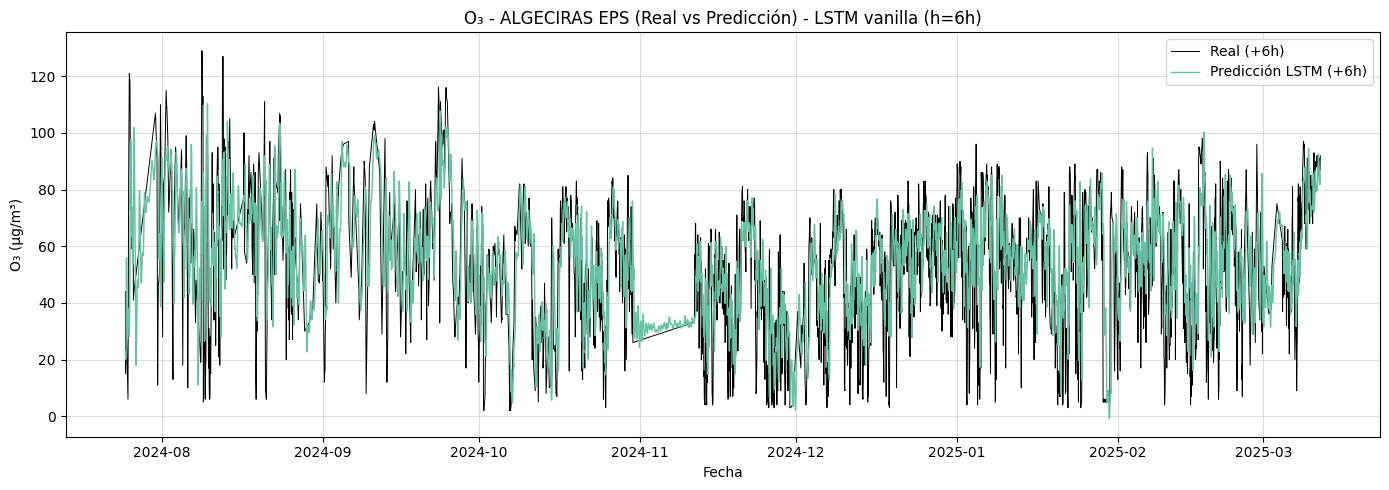

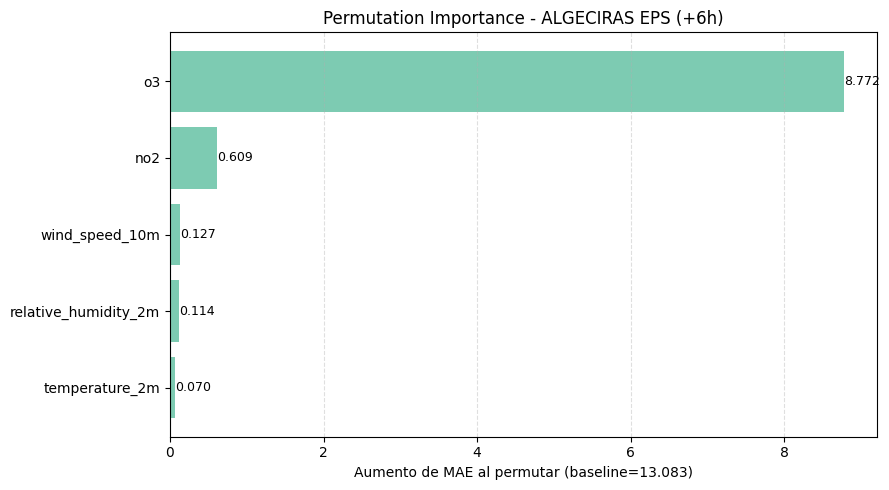

In [ ]:
salida = train_lstm_station_vanilla_multi(
    df_por_estacion["ALGECIRAS EPS"],
    lookback=72, horizon=6, horizon_idx=5,
    epochs=50, batch_size=128,
    units=64, drop=0.2,
    plot_color="#66c2a5",
    nombre_estacion="ALGECIRAS EPS"
)

Epoch 1/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 0.1513 - val_loss: 0.0810 - learning_rate: 0.0010
Epoch 2/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0763 - val_loss: 0.0690 - learning_rate: 0.0010
Epoch 3/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0679 - val_loss: 0.0640 - learning_rate: 0.0010
Epoch 4/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0627 - val_loss: 0.0602 - learning_rate: 0.0010
Epoch 5/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0571 - val_loss: 0.0547 - learning_rate: 0.0010
Epoch 6/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0531 - val_loss: 0.0542 - learning_rate: 0.0010
Epoch 7/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0503 - val_loss: 0.0531 - learning_rate: 0.0010
Epoch 8/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0481 - val_loss: 0.0523 - learning_rate: 0.0010
Epoch 9/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0465 - val_loss: 0.0523 - learning_rate: 0.0010
E

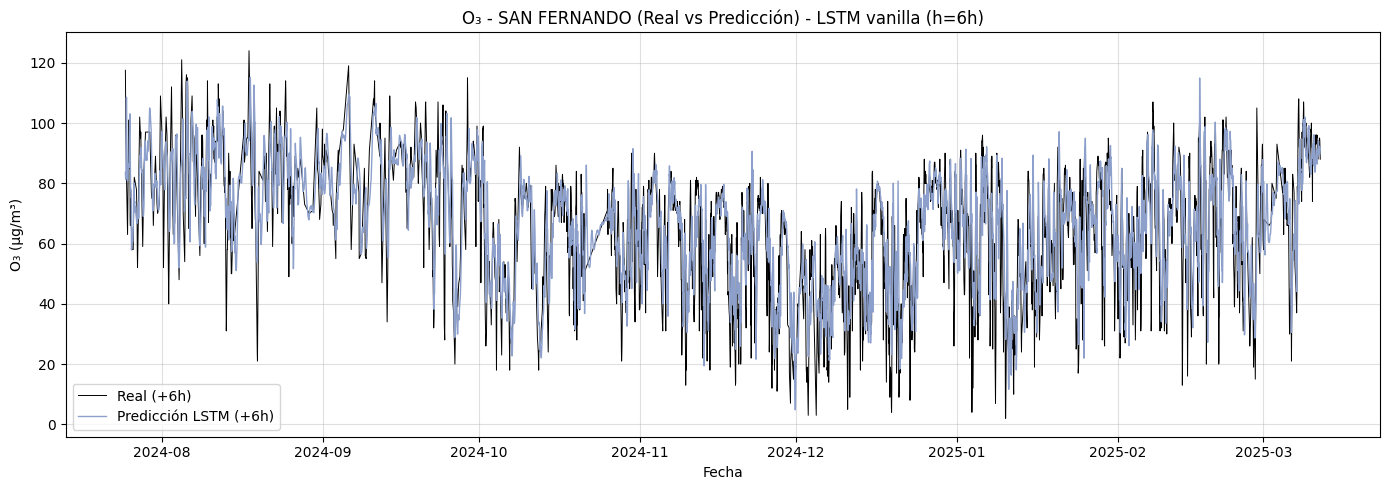

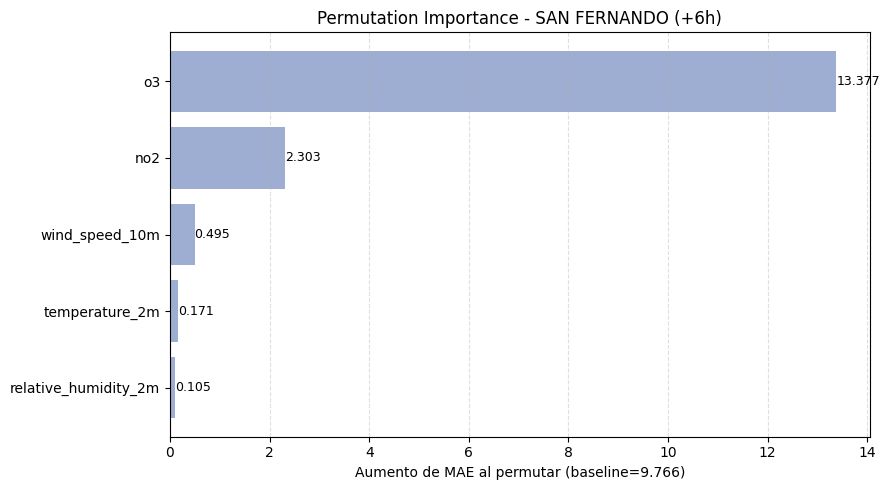

In [ ]:
salida = train_lstm_station_vanilla_multi(
    df_por_estacion["SAN FERNANDO"],
    lookback=72, horizon=6, horizon_idx=5,
    epochs=50, batch_size=128,
    units=64, drop=0.2,
    plot_color="#8da0cb",
    nombre_estacion="SAN FERNANDO"
)

Epoch 1/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 0.1523 - val_loss: 0.0912 - learning_rate: 0.0010
Epoch 2/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0883 - val_loss: 0.0679 - learning_rate: 0.0010
Epoch 3/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0746 - val_loss: 0.0656 - learning_rate: 0.0010
Epoch 4/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0690 - val_loss: 0.0636 - learning_rate: 0.0010
Epoch 5/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0649 - val_loss: 0.0604 - learning_rate: 0.0010
Epoch 6/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0617 - val_loss: 0.0605 - learning_rate: 0.0010
Epoch 7/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0593 - val_loss: 0.0576 - learning_rate: 0.0010
Epoch 8/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0574 - val_loss: 0.0572 - learning_rate: 0.0010
Epoch 9/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0566 - val_loss: 0.0556 - learning_rate: 0.0010
E

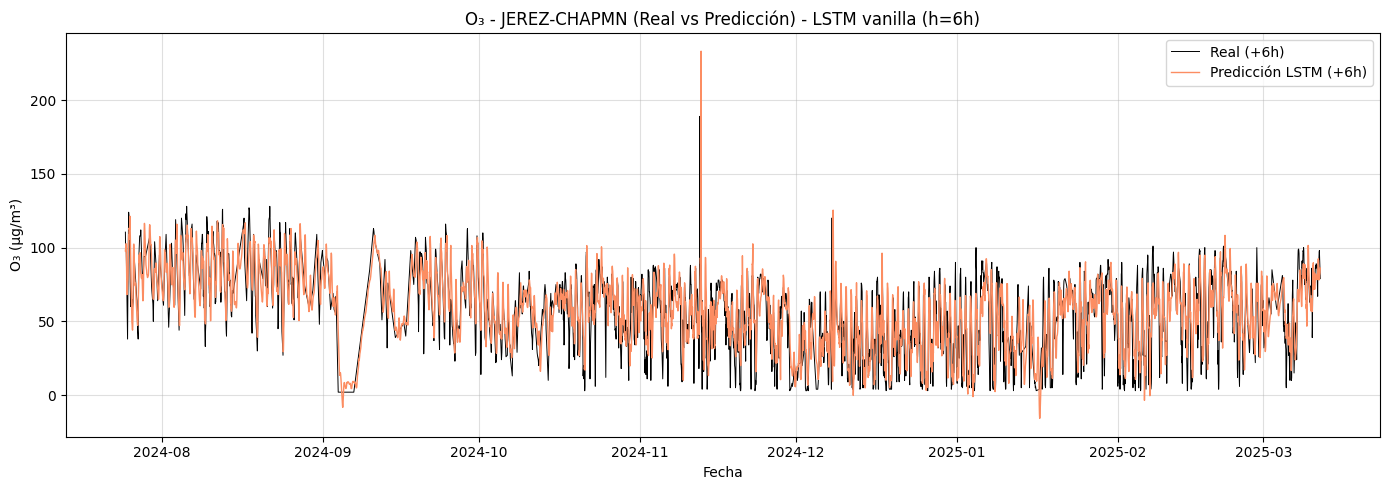

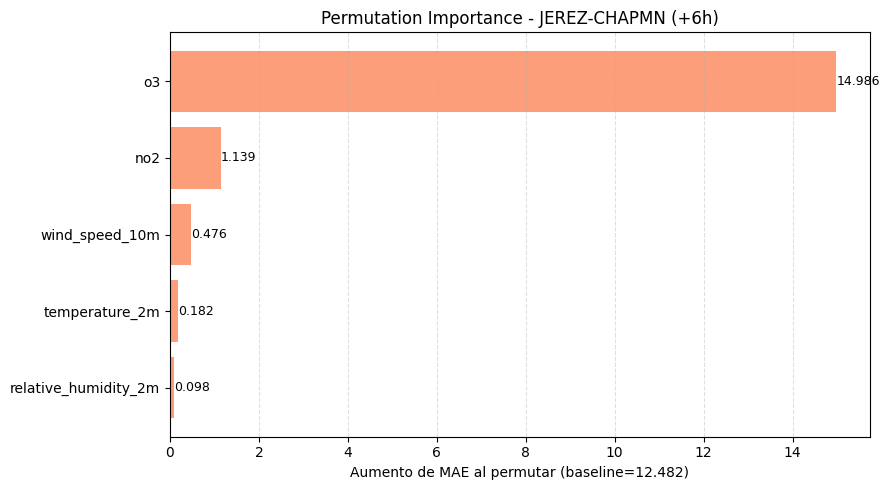

In [ ]:
salida = train_lstm_station_vanilla_multi(
    df_por_estacion["JEREZ-CHAPMN"],
    lookback=72, horizon=6, horizon_idx=5,
    epochs=50, batch_size=128,
    units=64, drop=0.2,
    plot_color="#fc8d62",
    nombre_estacion="JEREZ-CHAPMN"
)